In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
user_df = pd.read_csv('users.csv')
post_df = pd.read_csv('posts.csv')

In [3]:
feed_df = pd.read_csv('feeds_2.csv')

## 1. Info about datasets

#### Users:

In [4]:
user_df.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [5]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163205 entries, 0 to 163204
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    163205 non-null  int64 
 1   gender     163205 non-null  int64 
 2   age        163205 non-null  int64 
 3   country    163205 non-null  object
 4   city       163205 non-null  object
 5   exp_group  163205 non-null  int64 
 6   os         163205 non-null  object
 7   source     163205 non-null  object
dtypes: int64(4), object(4)
memory usage: 10.0+ MB


In [6]:
user_df.isna().sum()

user_id      0
gender       0
age          0
country      0
city         0
exp_group    0
os           0
source       0
dtype: int64

In [7]:
user_df.nunique()

user_id      163205
gender            2
age              76
country          11
city           3915
exp_group         5
os                2
source            2
dtype: int64

In [8]:
user_df.duplicated().sum()

0

#### Posts:

In [9]:
post_df.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [10]:
post_df.isna().sum()

post_id    0
text       0
topic      0
dtype: int64

In [11]:
post_df.nunique()

post_id    7023
text       6924
topic         7
dtype: int64

In [12]:
post_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7023 entries, 0 to 7022
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   post_id  7023 non-null   int64 
 1   text     7023 non-null   object
 2   topic    7023 non-null   object
dtypes: int64(1), object(2)
memory usage: 164.7+ KB


In [13]:
post_df.duplicated().sum()

0

#### Feeds:

In [14]:
feed_df['user_id'].value_counts()

24972     265
114976    264
142343    264
14817     263
90643     262
         ... 
48900      23
17799      23
128594     22
67199      22
68320      20
Name: user_id, Length: 163205, dtype: int64

In [15]:
feed_df = feed_df.sort_values(by='user_id').head(100000) # сократим кол-во строк в датасете
feed_df = feed_df[feed_df['action'] != 'like'].drop('action', axis=1)

In [16]:
feed_df.head()

,timestamp,user_id,post_id,target
5003405,2021-11-13 19:56:24,200,28,0
2153696,2021-10-29 19:24:04,200,2,0
12095690,2021-12-24 14:00:21,200,7042,0
9580835,2021-10-06 15:26:01,200,438,0
6023591,2021-10-06 15:15:32,200,1141,0


In [17]:
feed_df.isna().sum()

timestamp    0
user_id      0
post_id      0
target       0
dtype: int64

In [18]:
feed_df.nunique()

timestamp    88664
user_id        809
post_id       6831
target           2
dtype: int64

In [19]:
feed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89324 entries, 5003405 to 17089200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  89324 non-null  object
 1   user_id    89324 non-null  int64 
 2   post_id    89324 non-null  int64 
 3   target     89324 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 3.4+ MB


In [20]:
feed_df.timestamp = pd.to_datetime(feed_df.timestamp)

In [21]:
feed_df.duplicated().sum()

0

## 2. Preprocessing

#### TF IDF

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer 

import re
import string
import nltk
nltk.download('wordnet')

wnl = WordNetLemmatizer()

def preprocessing(line, token=wnl):
    line = line.lower() # приводим все символы строки к нижнему регистру
    line = re.sub(r'[{}]'.format(string.punctuation), ' ', line) # заменяем все знаки пунктуации в строке на пробелы
    line = line.replace('\n\n', ' ').replace('\n', ' ') # заменяем перенос строки и двойной перенос строки на пробелы
    line = ' '.join([token.lemmatize(x) for x in line.split(' ')]) # создаем строку из списка слов в строке, разделенную по пробелам, где к каждоиму слову была применена лемматизация
    return line

tfidf = TfidfVectorizer(
    preprocessor=preprocessing
)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Пользователь\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [23]:
tfidf_data = (
    tfidf
    .fit_transform(post_df['text'])
    .toarray()
)

tfidf_data = pd.DataFrame(
    tfidf_data,
    index = post_df.post_id,
    columns = tfidf.get_feature_names_out()
)

In [24]:
from sklearn.decomposition import PCA

def get_pca_text(n_components, data): # функция, в которой реализуется PCA
    centered = data - data.mean()
    pca = PCA(n_components)
    pca_decomp = pca.fit_transform(centered)
    pca_decomp = pd.DataFrame(pca_decomp, columns = [f'PCA_{i}' for i in range(pca_decomp.shape[1])]).set_index(tfidf_data.index)
    return pca_decomp

pca_decomp = get_pca_text(n_components=80, data=tfidf_data)

#### Merging table and new features

In [25]:
def merged_table(pca_decomp, post_df):
    post_df = post_df.join(pca_decomp).drop('text', axis=1)
    data = pd.merge(feed_df, user_df, on='user_id', how='left').merge(post_df, how='left', on='post_id')
    return data.set_index(['user_id', 'post_id'])

data = merged_table(pca_decomp=pca_decomp, post_df=post_df)

In [26]:
data.shape

(89324, 90)

In [27]:
data.isna().sum().sort_values(ascending=False)

PCA_35       3643
PCA_36       3643
PCA_56       3643
PCA_55       3643
PCA_54       3643
             ... 
exp_group       0
os              0
source          0
topic           0
timestamp       0
Length: 90, dtype: int64

In [28]:
data['target'].value_counts()[1] / data['target'].value_counts()[0] * 100

13.47196991831705

In [29]:
data['gender'] = data['gender'].astype('object')
data['exp_group'] = data['exp_group'].astype('object')

cat_cols = list(data.select_dtypes(include='object').columns) 
num_cols = list(data.select_dtypes(exclude='object').columns) 
cat_cols, num_cols

(['gender', 'country', 'city', 'exp_group', 'os', 'source', 'topic'],
 ['timestamp',
  'target',
  'age',
  'PCA_0',
  'PCA_1',
  'PCA_2',
  'PCA_3',
  'PCA_4',
  'PCA_5',
  'PCA_6',
  'PCA_7',
  'PCA_8',
  'PCA_9',
  'PCA_10',
  'PCA_11',
  'PCA_12',
  'PCA_13',
  'PCA_14',
  'PCA_15',
  'PCA_16',
  'PCA_17',
  'PCA_18',
  'PCA_19',
  'PCA_20',
  'PCA_21',
  'PCA_22',
  'PCA_23',
  'PCA_24',
  'PCA_25',
  'PCA_26',
  'PCA_27',
  'PCA_28',
  'PCA_29',
  'PCA_30',
  'PCA_31',
  'PCA_32',
  'PCA_33',
  'PCA_34',
  'PCA_35',
  'PCA_36',
  'PCA_37',
  'PCA_38',
  'PCA_39',
  'PCA_40',
  'PCA_41',
  'PCA_42',
  'PCA_43',
  'PCA_44',
  'PCA_45',
  'PCA_46',
  'PCA_47',
  'PCA_48',
  'PCA_49',
  'PCA_50',
  'PCA_51',
  'PCA_52',
  'PCA_53',
  'PCA_54',
  'PCA_55',
  'PCA_56',
  'PCA_57',
  'PCA_58',
  'PCA_59',
  'PCA_60',
  'PCA_61',
  'PCA_62',
  'PCA_63',
  'PCA_64',
  'PCA_65',
  'PCA_66',
  'PCA_67',
  'PCA_68',
  'PCA_69',
  'PCA_70',
  'PCA_71',
  'PCA_72',
  'PCA_73',
  'PCA_74',
  'P

In [30]:
def new_features(data, cat_cols):
    data['hour'] = pd.to_datetime(data.timestamp).apply(lambda x: x.hour)
    data['month'] = pd.to_datetime(data.timestamp).apply(lambda x: x.month)
    data['day_of_week'] = pd.to_datetime(data.timestamp).apply(lambda x: x.day_of_week)

    for col in cat_cols:
        if data[col].nunique() < 3:
            ohe = pd.get_dummies(data[col], prefix=col, drop_first=True)
            data = pd.concat((ohe, data.drop(col, axis=1)), axis=1)
            
    return data

data = new_features(data=data, cat_cols=cat_cols)

c:\Users\Пользователь\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [31]:
data.head()

os_iOS  gender_1           timestamp  target  age country  \
user_id post_id                                                              
200     28            0         1 2021-11-13 19:56:24       0   34  Russia   
        2             0         1 2021-10-29 19:24:04       0   34  Russia   
        7042          0         1 2021-12-24 14:00:21       0   34  Russia   
        438           0         1 2021-10-06 15:26:01       0   34  Russia   
        1141          0         1 2021-10-06 15:15:32       0   34  Russia   

                      city exp_group     topic     PCA_0  ...    PCA_73  \
user_id post_id                                           ...             
200     28       Degtyarsk         3  business  0.035194  ... -0.031591   
        2        Degtyarsk         3  business -0.108728  ...  0.005191   
        7042     Degtyarsk         3     movie -0.085597  ...  0.001836   
        438      Degtyarsk         3  business -0.100397  ... -0.001784   
        1141     Degtyarsk         3  politics -0.214752  ... -0.010406   

                   PCA_74    PCA_75    PCA_76    PCA_77    PCA_78    PCA_79  \
user_id post_id                                                               
200     28      -0.007238  0.010260 -0.001653 -0.021841 -0.016983  0.018639   
        2        0.018754  0.025230 -0.018209 -0.002600  0.000687  0.017617   
        7042    -0.018078 -0.006285 -0.024559  0.009348 -0.022899 -0.010656   
        438     -0.018507 -0.011443  0.012857 -0.017541 -0.008656  0.001994   
        1141     0.006134  0.008439  0.013260 -0.038578 -0.043137  0.006578   

                 hour  month  day_of_week  
user_id post_id                            
200     28         19     11            5  
        2          19     10            4  
        7042       14     12            4  
        438        15     10            2  
        1141       15     10            2  

[5 rows x 92 columns]

In [32]:
data['timestamp'].min(), data['timestamp'].max()

(Timestamp('2021-10-01 06:07:31'), Timestamp('2021-12-29 23:18:03'))

#### Splitting data of timestamp

In [33]:
def split_data(data):
    data_train = data[data['timestamp'] < '2021-12-10 00:00:00']
    data_test = data[data['timestamp'] >= '2021-12-10 00:00:00']

    data_train = data_train.drop('timestamp', axis=1)
    data_test = data_test.drop('timestamp', axis=1)

    X_train, X_test = data_train.drop('target', axis=1), data_test.drop('target', axis=1)
    y_train, y_test = data_train['target'], data_test['target']

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(data)

In [34]:
X_train.shape, X_test.shape

((69873, 90), (19451, 90))

## 3. Training

####  Function where probabilities are sorted

In [35]:
def probs(X, y, model, top = 5):
    indexes_u = [x[0] for x in X.index.values.tolist()]
    indexes_p = [x[1] for x in X.index.values.tolist()]
    res = model.predict_proba(X)
    res[:,1].tolist()

    predictions_df = pd.DataFrame({
        'user_id': indexes_u,
        'post_id': indexes_p,
        'recommendation_proba': res[:,1]
    }).sort_values(by='user_id')

    def sorted_prob(group):
        group = group.nlargest(top, 'recommendation_proba')
        return group

    predictions_df_group = predictions_df.groupby('user_id').apply(sorted_prob)
    predictions_df_group.reset_index(drop=True, inplace=True)
    final_df = pd.merge(predictions_df_group, y, left_on=['user_id', 'post_id'], right_index=True, how='left')
    return final_df.set_index(['user_id', 'post_id'])

#### Catboost with default parametrs and 100 iterations

In [36]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, classification_report

cb_def = CatBoostClassifier(random_state=12345, verbose=1, iterations=100, cat_features=list(data.select_dtypes(include='object').columns))
cb_def.fit(X_train, y_train)

Learning rate set to 0.5
0:	learn: 0.4224884	total: 337ms	remaining: 33.4s
1:	learn: 0.3665693	total: 717ms	remaining: 35.1s
2:	learn: 0.3509309	total: 972ms	remaining: 31.4s
3:	learn: 0.3468547	total: 1.22s	remaining: 29.3s
4:	learn: 0.3432183	total: 1.42s	remaining: 27s
5:	learn: 0.3418400	total: 1.65s	remaining: 25.9s
6:	learn: 0.3405611	total: 1.85s	remaining: 24.6s
7:	learn: 0.3398249	total: 1.98s	remaining: 22.8s
8:	learn: 0.3392662	total: 2.13s	remaining: 21.6s
9:	learn: 0.3386693	total: 2.26s	remaining: 20.4s
10:	learn: 0.3381786	total: 2.41s	remaining: 19.5s
11:	learn: 0.3377053	total: 2.55s	remaining: 18.7s
12:	learn: 0.3374370	total: 2.69s	remaining: 18s
13:	learn: 0.3368031	total: 2.84s	remaining: 17.5s
14:	learn: 0.3366266	total: 3.01s	remaining: 17.1s
15:	learn: 0.3361610	total: 3.15s	remaining: 16.5s
16:	learn: 0.3357808	total: 3.25s	remaining: 15.9s
17:	learn: 0.3355317	total: 3.36s	remaining: 15.3s
18:	learn: 0.3355073	total: 3.41s	remaining: 14.5s
19:	learn: 0.3350268

#### Quality metrics results

In [37]:
print(f'ROC-AUC TRAIN: {roc_auc_score(y_train, cb_def.predict_proba(X_train)[:,1])}')
print(f'ROC-AUC TEST: {roc_auc_score(y_test, cb_def.predict_proba(X_test)[:,1])}')

ROC-AUC TRAIN: 0.8053440293774154
ROC-AUC TEST: 0.5968072230209598


In [38]:
print('Train:')
print(classification_report(y_train, cb_def.predict(X_train)))
print('Test:')
print(classification_report(y_test, cb_def.predict(X_test)))

Train:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94     61932
           1       0.87      0.04      0.08      7941

    accuracy                           0.89     69873
   macro avg       0.88      0.52      0.51     69873
weighted avg       0.89      0.89      0.84     69873

Test:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     16787
           1       0.22      0.01      0.02      2664

    accuracy                           0.86     19451
   macro avg       0.54      0.50      0.47     19451
weighted avg       0.78      0.86      0.80     19451



In [39]:
prediction_train = probs(X_train, y_train, cb_def)
prediction_test = probs(X_test, y_test, cb_def)
prediction_test.head(10)

recommendation_proba  target
user_id post_id                              
200     1452                 0.225067       1
        3413                 0.164250       0
        3232                 0.144100       0
        7042                 0.123202       0
        5558                 0.121418       0
201     1195                 0.400222       0
        4770                 0.352804       0
        1410                 0.295747       0
        1755                 0.224065       0
        1718                 0.194019       0

#### Hitrate metric:

In [40]:
def hitrate(predictions):
    arr_hit = []
    n_users = predictions.index.get_level_values('user_id').nunique()

    sum_hit = predictions.groupby('user_id')['target'].sum()

    for i in sum_hit:
        if i > 0:
            arr_hit.append(1)
        else:
            arr_hit.append(0)

    hitrate = np.mean(arr_hit)
    
    return hitrate

In [41]:
train_hitrate = hitrate(prediction_train)
test_hitrate = hitrate(prediction_test)

print(f'Среднее hitrate@5 train: {train_hitrate}')
print(f'Среднее hitrate@5 test: {test_hitrate}')

Среднее hitrate@5 train: 0.8751545117428925
Среднее hitrate@5 test: 0.5522193211488251


#### Function for highlighting important features

In [42]:
def feature_importance(data, model):
    fi_df = pd.DataFrame({
        'feature_names': data.drop(['target', 'timestamp'], axis=1).columns,
        'feature_importance': model.feature_importances_
    }).sort_values(by='feature_importance', ascending=False)[:20]
    return fi_df

def plot_feature_importance(fi_df, model_type=str): 
    plt.figure(figsize=(10, 8))
    sns.barplot(x='feature_importance', y='feature_names', data=fi_df)
    plt.title(f'{model_type} top 20 feature importance')

   

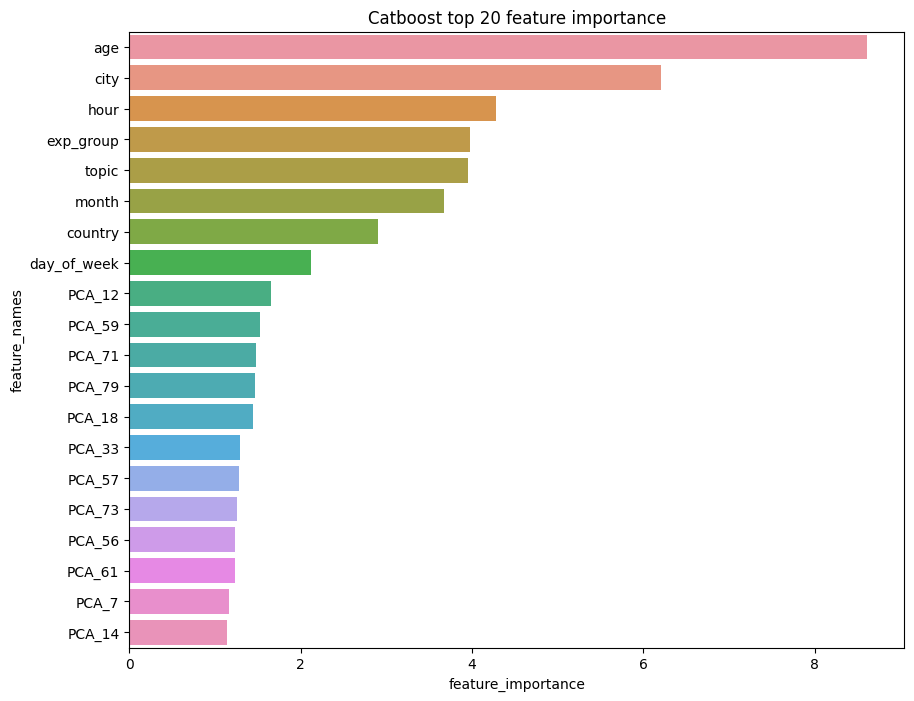

In [43]:
col_top_20 = feature_importance(data=data, model=cb_def)
plot_feature_importance(col_top_20, 'Catboost')

#### Catboost with top-20 important features and 100 iterations

In [44]:
X_train_top_20, X_test_top_20 = X_train[col_top_20['feature_names'].tolist()], X_test[col_top_20['feature_names'].tolist()]

cb_top_20 = CatBoostClassifier(random_state=12345, verbose=1, iterations=100, cat_features=list(X_train_top_20.select_dtypes(include='object').columns))
cb_top_20.fit(X_train_top_20, y_train)

Learning rate set to 0.5
0:	learn: 0.4203172	total: 129ms	remaining: 12.8s
1:	learn: 0.3647837	total: 266ms	remaining: 13s
2:	learn: 0.3519039	total: 352ms	remaining: 11.4s
3:	learn: 0.3479081	total: 437ms	remaining: 10.5s
4:	learn: 0.3438353	total: 535ms	remaining: 10.2s
5:	learn: 0.3425748	total: 651ms	remaining: 10.2s
6:	learn: 0.3420326	total: 780ms	remaining: 10.4s
7:	learn: 0.3414622	total: 900ms	remaining: 10.4s
8:	learn: 0.3413300	total: 951ms	remaining: 9.61s
9:	learn: 0.3397339	total: 1.05s	remaining: 9.49s
10:	learn: 0.3395138	total: 1.15s	remaining: 9.28s
11:	learn: 0.3390859	total: 1.24s	remaining: 9.1s
12:	learn: 0.3388249	total: 1.33s	remaining: 8.92s
13:	learn: 0.3384736	total: 1.41s	remaining: 8.69s
14:	learn: 0.3379578	total: 1.5s	remaining: 8.48s
15:	learn: 0.3376730	total: 1.58s	remaining: 8.29s
16:	learn: 0.3372092	total: 1.66s	remaining: 8.11s
17:	learn: 0.3369882	total: 1.74s	remaining: 7.92s
18:	learn: 0.3364395	total: 1.83s	remaining: 7.79s
19:	learn: 0.3342472

In [45]:
print(f'ROC-AUC TRAIN: {roc_auc_score(y_train, cb_top_20.predict_proba(X_train_top_20)[:,1])}')
print(f'ROC-AUC TEST: {roc_auc_score(y_test, cb_top_20.predict_proba(X_test_top_20)[:,1])}')

ROC-AUC TRAIN: 0.7783773595053938
ROC-AUC TEST: 0.5944611101540571


In [46]:
print('Train:')
print(classification_report(y_train, cb_top_20.predict(X_train_top_20)))
print('Test:')
print(classification_report(y_test, cb_top_20.predict(X_test_top_20)))

Train:


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     61932
           1       0.87      0.03      0.06      7941

    accuracy                           0.89     69873
   macro avg       0.88      0.51      0.50     69873
weighted avg       0.89      0.89      0.84     69873

Test:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92     16787
           1       0.18      0.01      0.01      2664

    accuracy                           0.86     19451
   macro avg       0.52      0.50      0.47     19451
weighted avg       0.77      0.86      0.80     19451



In [47]:
prediction_train_top_20 = probs(X_train_top_20, y_train, cb_top_20)
prediction_test_top_20 = probs(X_test_top_20, y_test, cb_top_20)

print(f'Среднее hitrate@5 train: {hitrate(prediction_train_top_20)}')
print(f'Среднее hitrate@5 test: {hitrate(prediction_test_top_20)}')

Среднее hitrate@5 train: 0.8553770086526576
Среднее hitrate@5 test: 0.54177545691906


После взятия топ 20 самых важных фичей, качество на тесте не улучшилось, но модель стала работать значительно быстрее, поэтому можно увеличить количество итераций.

In [48]:
cb_top_20 = CatBoostClassifier(random_state=12345, verbose=1, iterations=500, cat_features=list(X_train_top_20.select_dtypes(include='object').columns))
cb_top_20.fit(X_train_top_20, y_train)

Learning rate set to 0.119261
0:	learn: 0.6059795	total: 127ms	remaining: 1m 3s
1:	learn: 0.5408754	total: 235ms	remaining: 58.4s
2:	learn: 0.4924025	total: 280ms	remaining: 46.4s
3:	learn: 0.4562653	total: 341ms	remaining: 42.3s
4:	learn: 0.4285105	total: 467ms	remaining: 46.2s
5:	learn: 0.4094142	total: 570ms	remaining: 46.9s
6:	learn: 0.3946708	total: 652ms	remaining: 45.9s
7:	learn: 0.3830473	total: 770ms	remaining: 47.4s
8:	learn: 0.3748914	total: 879ms	remaining: 47.9s
9:	learn: 0.3682039	total: 973ms	remaining: 47.7s
10:	learn: 0.3633352	total: 1.05s	remaining: 46.7s
11:	learn: 0.3596959	total: 1.16s	remaining: 47.3s
12:	learn: 0.3560468	total: 1.27s	remaining: 47.6s
13:	learn: 0.3539768	total: 1.37s	remaining: 47.7s
14:	learn: 0.3513604	total: 1.48s	remaining: 47.7s
15:	learn: 0.3491354	total: 1.57s	remaining: 47.6s
16:	learn: 0.3472975	total: 1.76s	remaining: 50.1s
17:	learn: 0.3463178	total: 1.94s	remaining: 52s
18:	learn: 0.3453251	total: 2.11s	remaining: 53.3s
19:	learn: 0.

#### Quality metrics results

In [49]:
print(f"Train ROC-AUC score: {roc_auc_score(y_train, cb_top_20.predict_proba(X_train_top_20)[:, 1])}")
print(f"Test ROC-AUC score: {roc_auc_score(y_test, cb_top_20.predict_proba(X_test_top_20)[:, 1])}")

Train ROC-AUC score: 0.8017822424036769
Test ROC-AUC score: 0.6186401299733044


In [50]:
prediction_train_top_20 = probs(X_train_top_20, y_train, cb_top_20)
prediction_test_top_20 = probs(X_test_top_20, y_test, cb_top_20)

print(f'Среднее hitrate@5 train: {hitrate(prediction_train_top_20)}')
print(f'Среднее hitrate@5 test: {hitrate(prediction_test_top_20)}')

Среднее hitrate@5 train: 0.9085290482076638
Среднее hitrate@5 test: 0.5757180156657964


Качество на трейне и на тесте немного улучшилось.

#### Searching optimal parametrs LGBM

In [51]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

X_train_top_20[['city', 'exp_group', 'topic', 'country']] = X_train_top_20[['city', 'exp_group', 'topic', 'country']].astype('category')

params = {'n_estimators': [100, 500],
          'max_depth': [2, 3, 5, 100],
          'learning_rate': [0.1, 0.01, 0.001]}

grid = GridSearchCV(LGBMClassifier(), params)
grid.fit(X_train_top_20, y_train)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_16132\3352321422.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_top_20[['city', 'exp_group', 'topic', 'country']] = X_train_top_20[['city', 'exp_group', 'topic', 'country']].astype('category')


GridSearchCV(estimator=LGBMClassifier(objective='binary'),
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [2, 3, 5, 100],
                         'n_estimators': [100, 500]})

In [52]:
grid.best_estimator_

LGBMClassifier(max_depth=2, n_estimators=100, objective='binary')

#### LGBM with optimal parametrs

In [53]:
obj_cols = X_test.select_dtypes(include='object').columns.tolist()
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
obj_cols

['country', 'city', 'exp_group', 'topic']

In [54]:
X_train_cat[obj_cols] = X_train_cat[obj_cols].astype('category')
X_test_cat[obj_cols] = X_test_cat[obj_cols].astype('category')


lgbm = LGBMClassifier(max_depth=2, n_estimators=100)
lgbm.fit(X_train_cat, y_train)

LGBMClassifier(max_depth=2, n_estimators=100, objective='binary')

#### Quality metrics results

In [55]:
print(f"Train ROC-AUC score: {roc_auc_score(y_train, lgbm.predict_proba(X_train_cat)[:, 1])}")
print(f"Test ROC-AUC score: {roc_auc_score(y_test, lgbm.predict_proba(X_test_cat)[:, 1])}")

Train ROC-AUC score: 0.6485218618829074
Test ROC-AUC score: 0.6115309626657695


In [56]:
pred_lgbm_train = probs(X_train_cat, y_train, lgbm)
pred_lgbm_test = probs(X_test_cat, y_test, lgbm)

print(f'Среднее hitrate@5 train: {hitrate(pred_lgbm_train)}')
print(f'Среднее hitrate@5 test: {hitrate(pred_lgbm_test)}')

Среднее hitrate@5 train: 0.6353522867737948
Среднее hitrate@5 test: 0.5391644908616188


LGBMClassifier выдает меньшее качество на всех фичах.

#### LGBM with top-20 important features

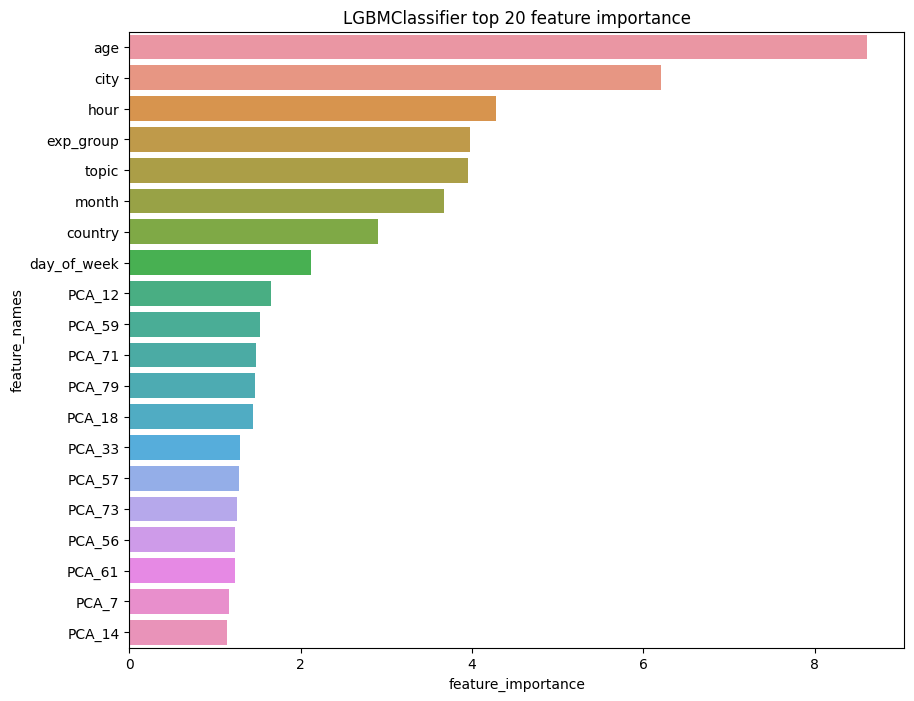

In [57]:
col_top_20_lgbm = feature_importance(data=data, model=lgbm)
plot_feature_importance(col_top_20, 'LGBMClassifier')

In [58]:
X_train_top_20, X_test_top_20 = X_train[col_top_20['feature_names'].tolist()], X_test[col_top_20['feature_names'].tolist()]
X_train_top_20

age       city  hour exp_group     topic  month country  \
user_id post_id                                                            
200     28        34  Degtyarsk    19         3  business     11  Russia   
        2         34  Degtyarsk    19         3  business     10  Russia   
        438       34  Degtyarsk    15         3  business     10  Russia   
        1141      34  Degtyarsk    15         3  politics     10  Russia   
        7175      34  Degtyarsk    20         3     movie     10  Russia   
...              ...        ...   ...       ...       ...    ...     ...   
1008    6069      16    Korocha     7         4     movie     10  Russia   
        5587      16    Korocha    15         4     movie     10  Russia   
        2277      16    Korocha     8         4      tech     11  Russia   
        3937      16    Korocha    22         4     covid     11  Russia   
        5397      16    Korocha    16         4     movie     11  Russia   

                 day_of_week    PCA_12    PCA_59    PCA_71    PCA_79  \
user_id post_id                                                        
200     28                 5  0.002327  0.004896  0.007821  0.018639   
        2                  4  0.036271 -0.029555  0.044362  0.017617   
        438                2 -0.030971 -0.011442  0.003814  0.001994   
        1141               2 -0.019650  0.022379  0.013474  0.006578   
        7175               3  0.019558  0.019451  0.051868 -0.025435   
...                      ...       ...       ...       ...       ...   
1008    6069               6 -0.006290  0.032270  0.014331  0.014664   
        5587               6  0.018907  0.030950  0.046085  0.006548   
        2277               1 -0.049288  0.016491  0.041173 -0.034788   
        3937               3 -0.019436 -0.021725 -0.031095  0.026348   
        5397               0  0.024455  0.025164  0.022843  0.003264   

                   PCA_18    PCA_33    PCA_57    PCA_73    PCA_56    PCA_61  \
user_id post_id                                                               
200     28       0.026814 -0.033474  0.004595 -0.031591 -0.034496 -0.002116   
        2        0.005042  0.010389 -0.015919  0.005191  0.042452 -0.025727   
        438     -0.020219 -0.007560  0.017023 -0.001784  0.031592  0.014459   
        1141    -0.012667  0.001956 -0.010491 -0.010406 -0.008049  0.031564   
        7175     0.007349 -0.003466 -0.007421  0.009413  0.032579  0.014837   
...                   ...       ...       ...       ...       ...       ...   
1008    6069    -0.004459 -0.059267 -0.018661 -0.001910 -0.000468  0.003977   
        5587     0.024400 -0.008299  0.013445  0.001114 -0.033211  0.059934   
        2277     0.023894 -0.010587  0.008085 -0.037335  0.006949 -0.014628   
        3937     0.003593  0.037600  0.003359  0.019543 -0.015194  0.033958   
        5397     0.092815  0.047729 -0.028808 -0.009881  0.023351  0.011733   

                    PCA_7    PCA_14  
user_id post_id                      
200     28      -0.004236  0.016761  
        2       -0.002087  0.007317  
        438     -0.008889  0.013816  
        1141    -0.000647 -0.006429  
        7175     0.013716 -0.016336  
...                   ...       ...  
1008    6069     0.020389  0.020380  
        5587    -0.021187  0.015851  
        2277     0.002947  0.011017  
        3937     0.014220  0.019602  
        5397    -0.031650  0.034931  

[69873 rows x 20 columns]

In [59]:
obj_cols_20 = X_test_top_20.select_dtypes(include='object').columns.tolist()
obj_cols_20

['city', 'exp_group', 'topic', 'country']

In [60]:
X_train_top_20[obj_cols_20] = X_train_top_20[obj_cols_20].astype('category')
X_test_top_20[obj_cols_20] = X_test_top_20[obj_cols_20].astype('category')


lgbm = LGBMClassifier(max_depth=2, n_estimators=100)
lgbm.fit(X_train_top_20, y_train)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_16132\3738576686.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_top_20[obj_cols_20] = X_train_top_20[obj_cols_20].astype('category')
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_16132\3738576686.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_top_20[obj_cols_20] = X_test_top_20[obj_cols_20].astype('category')


LGBMClassifier(max_depth=2, n_estimators=100, objective='binary')

#### Quality metrics results

In [61]:
print(f"Train ROC-AUC score: {roc_auc_score(y_train, lgbm.predict_proba(X_train_top_20)[:, 1])}")
print(f"Test ROC-AUC score: {roc_auc_score(y_test, lgbm.predict_proba(X_test_top_20)[:, 1])}")

Train ROC-AUC score: 0.6438264174893208
Test ROC-AUC score: 0.6089400742852819


In [62]:
pred_lgbm_train = probs(X_train_top_20, y_train, lgbm)
pred_lgbm_test = probs(X_test_top_20, y_test, lgbm)

print(f'Среднее hitrate@5 train: {hitrate(pred_lgbm_train)}')
print(f'Среднее hitrate@5 test: {hitrate(pred_lgbm_test)}')

Среднее hitrate@5 train: 0.6019777503090235
Среднее hitrate@5 test: 0.5456919060052219


Качество ухудшилось

#### XGBOOST:

In [63]:
from xgboost import XGBClassifier

xgboost = XGBClassifier(enable_categorical=True, tree_method='hist') # сообщили, что в датасете есть категориальные фичи и явно указали метод построения деревьев
xgboost.fit(X_train_cat, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

#### Quality metrics results

In [64]:
print(f"Train ROC-AUC score: {roc_auc_score(y_train, xgboost.predict_proba(X_train_cat)[:, 1])}")
print(f"Test ROC-AUC score: {roc_auc_score(y_test, xgboost.predict_proba(X_test_cat)[:, 1])}")

Train ROC-AUC score: 0.9739593501297023
Test ROC-AUC score: 0.5141875434140282


In [65]:
pred_xgboost_train = probs(X_train_cat, y_train, xgboost)
pred_xgboost_test = probs(X_test_cat, y_test, xgboost)

print(f'Среднее hitrate@5 train: {hitrate(pred_xgboost_train)}')
print(f'Среднее hitrate@5 test: {hitrate(pred_xgboost_test)}')

Среднее hitrate@5 train: 0.9814585908529048
Среднее hitrate@5 test: 0.5052219321148825


Модель явно переобучилась. Качество на тесте такое же, как при использовании алгоритма lgbm.

#### XGBOOST with top-20 important features

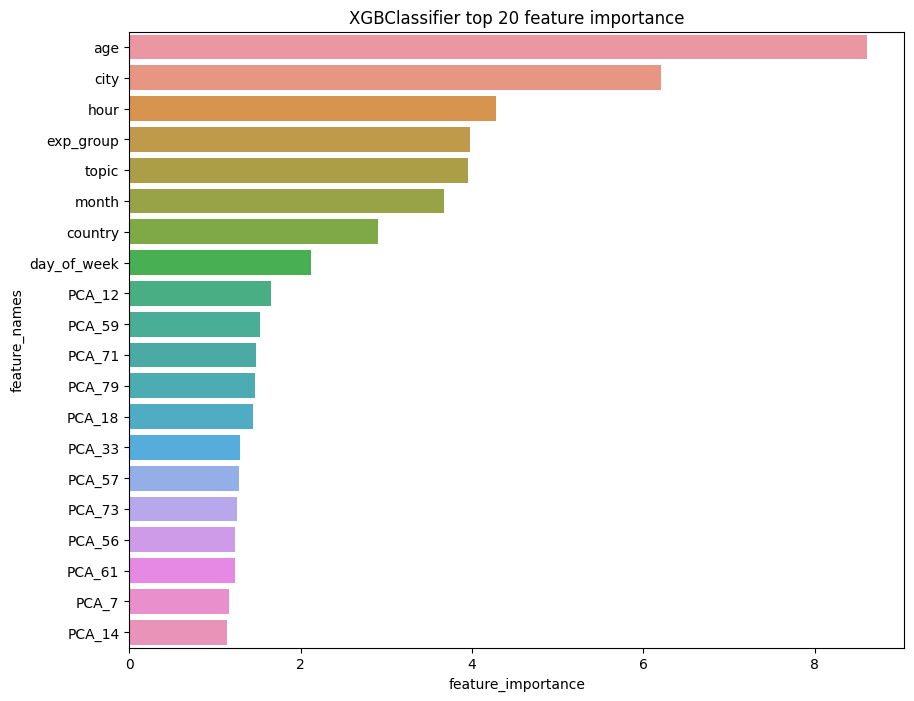

In [66]:
col_top_20_xgboost = feature_importance(data=data, model=xgboost)
plot_feature_importance(col_top_20, 'XGBClassifier')

In [67]:
X_train_top_20, X_test_top_20 = X_train[col_top_20['feature_names'].tolist()], X_test[col_top_20['feature_names'].tolist()]
obj_cols_20 = X_test_top_20.select_dtypes(include='object').columns.tolist()
obj_cols_20

['city', 'exp_group', 'topic', 'country']

In [68]:
X_train_top_20[obj_cols_20] = X_train_top_20[obj_cols_20].astype('category')
X_test_top_20[obj_cols_20] = X_test_top_20[obj_cols_20].astype('category')

xgboost = XGBClassifier(enable_categorical=True, tree_method='hist') 
xgboost.fit(X_train_top_20, y_train)

C:\Users\Пользователь\AppData\Local\Temp\ipykernel_16132\3426360323.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_top_20[obj_cols_20] = X_train_top_20[obj_cols_20].astype('category')
C:\Users\Пользователь\AppData\Local\Temp\ipykernel_16132\3426360323.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_top_20[obj_cols_20] = X_test_top_20[obj_cols_20].astype('category')


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=True,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

#### Quality metrics results

In [69]:
print(f"Train ROC-AUC score: {roc_auc_score(y_train, xgboost.predict_proba(X_train_top_20)[:, 1])}")
print(f"Test ROC-AUC score: {roc_auc_score(y_test, xgboost.predict_proba(X_test_top_20)[:, 1])}")

Train ROC-AUC score: 0.9480952885975586
Test ROC-AUC score: 0.5235039724897949


In [70]:
pred_xgboost_train = probs(X_train_top_20, y_train, xgboost)
pred_xgboost_test = probs(X_test_top_20, y_test, xgboost)

print(f'Среднее hitrate@5 train: {hitrate(pred_xgboost_train)}')
print(f'Среднее hitrate@5 test: {hitrate(pred_xgboost_test)}')

Среднее hitrate@5 train: 0.9740420271940667
Среднее hitrate@5 test: 0.5195822454308094


Таким образом, лучшей моделью оказалась Catboost на 20 фичах и 500 итерациях.